# MSIN0097: Predictive Analytics

# Individual Coursework

## American Sign Language (ASL) Detection

#### WORD COUNT: 1998

#### STUDENT NUMBER: 23098592
    
#### CANDIDATE NUMBER: HCXN4

## Table of Contents:
- 1. [Introduction](#Introduction)
- 2. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
   - 2.1 [Data Description](#Data-Introduction)
   - 2.2 [Data Visualisation](#Data-Visualisation)
- 3. [Data Preprocessing](#Data-Preprocessing)
   - 3.1. [Training, Test and Validation Set](#Training,-Test-and-Validation-Set)
   - 3.2. [Training and Data Augmentation](#Training-and-Data-Augmentation)
- 4. [Model Development and Optimization](#Model-Development-and-Optimization)
   - 4.1 [Model Exploration and Configuration](#Model-Exploration-and-Configuration)
   - 4.2 [Model Fine-Tuning and Integration](#Model-Fine-Tuning-and-Integration)
- 5. [Model Visualization](#Model-Visualization)
   - 5.1 [Attention Layer Identification](#Attention-Layer-Identification)
   - 5.2 [Grad-CAM Heatmap Generation](#Grad-CAM-Heatmap-Generation)
- 6. [Conclusion](#Conclusion)
- 7. [References](#References)

# 1.Introduction <a class="anchor" id="Introduction"></a>

The project aims to develop a robust deep learning model for American Sign Language (ASL) recognition from images, facilitating seamless communication for individuals with hearing impairments. Leveraging the expressive capabilities of ASL, the model serves as a vital tool in bridging communication gaps and fostering inclusivity. By harnessing the power of CNNs, the model endeavors to accurately classify hand gestures representing letters and digits, enabling real-time translation of ASL into text or speech. Through extensive data preprocessing, model development, and optimization, the project seeks to enhance the model's accuracy, generalizability, and real-world applicability. By effectively interpreting ASL gestures, the model not only facilitates communication but also empowers individuals with hearing disabilities in various domains, including education, healthcare, and accessibility services. This project aligns with the broader goal of leveraging artificial intelligence to create solutions that enhance accessibility and promote inclusivity in diverse communities.

In [4]:
#importing necessary packages to run the file
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# To display images within Jupyter Notebook
%matplotlib inline


# 2. Exploratory Data Analysis (EDA) <a class="anchor" id="Exploratory-Data-Analysis-(EDA)"></a>

## 2.1 Data Description <a class="anchor" id="Data-Introduction"></a>

The dataset, sourced from Kaggle, includes images representing the 10 digits and 26 letters of the English alphabet in American Sign Language (ASL). Each image is labeled with its corresponding letter, making it a supervised learning task. It features diverse hand signs captured in various orientations and lighting conditions, enhancing the model's robustness across real-world scenarios. This variety ensures accurate recognition and translation of ASL gestures, increasing practical applicability.

In [5]:
# Path where our data is located
first_path = "/content/drive/MyDrive/PRED_ASL_DATA/asl_dataset"

# To ensure class_labels are sorted to match your expected order
expected_order = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                  'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                  'u', 'v', 'w', 'x', 'y', 'z']

# Dynamically load class labels from directory names
class_labels = os.listdir(first_path)

# Sort class_labels to ensure they are in the expected order
class_labels = sorted(class_labels, key=lambda x: expected_order.index(x))

# Initialize lists to store filenames and their corresponding categories
file_names = []
category_list = []

#These lines of code iterate through each category label, list all files within the corresponding directory,
#prefix each filename with its category for easy identification, and populate lists with these filenames and 
#their associated categories for further processing.
for category in class_labels:
    if os.path.isdir(os.path.join(first_path, category)):
        filenames = os.listdir(os.path.join(first_path, category))
        filenames_with_prefix = [f"{category}/{filename}" for filename in filenames]
        file_names.extend(filenames_with_prefix)
        category_list.extend([category] * len(filenames))

# Create a DataFrame with two columns: filename and category, based on the lists compiled above
df = pd.DataFrame({"filename": file_names, "category": category_list})

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Verify the sorted class_labels
print("Sorted class labels:", class_labels)

# Display the first few rows to verify
print(df.head())

Sorted class labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
                             filename category
0  b/hand1_b_right_seg_1_cropped.jpeg        b
1    r/hand3_r_dif_seg_5_cropped.jpeg        r
2    y/hand1_y_top_seg_4_cropped.jpeg        y
3   3/hand1_3_left_seg_4_cropped.jpeg        3
4    t/hand5_t_dif_seg_4_cropped.jpeg        t


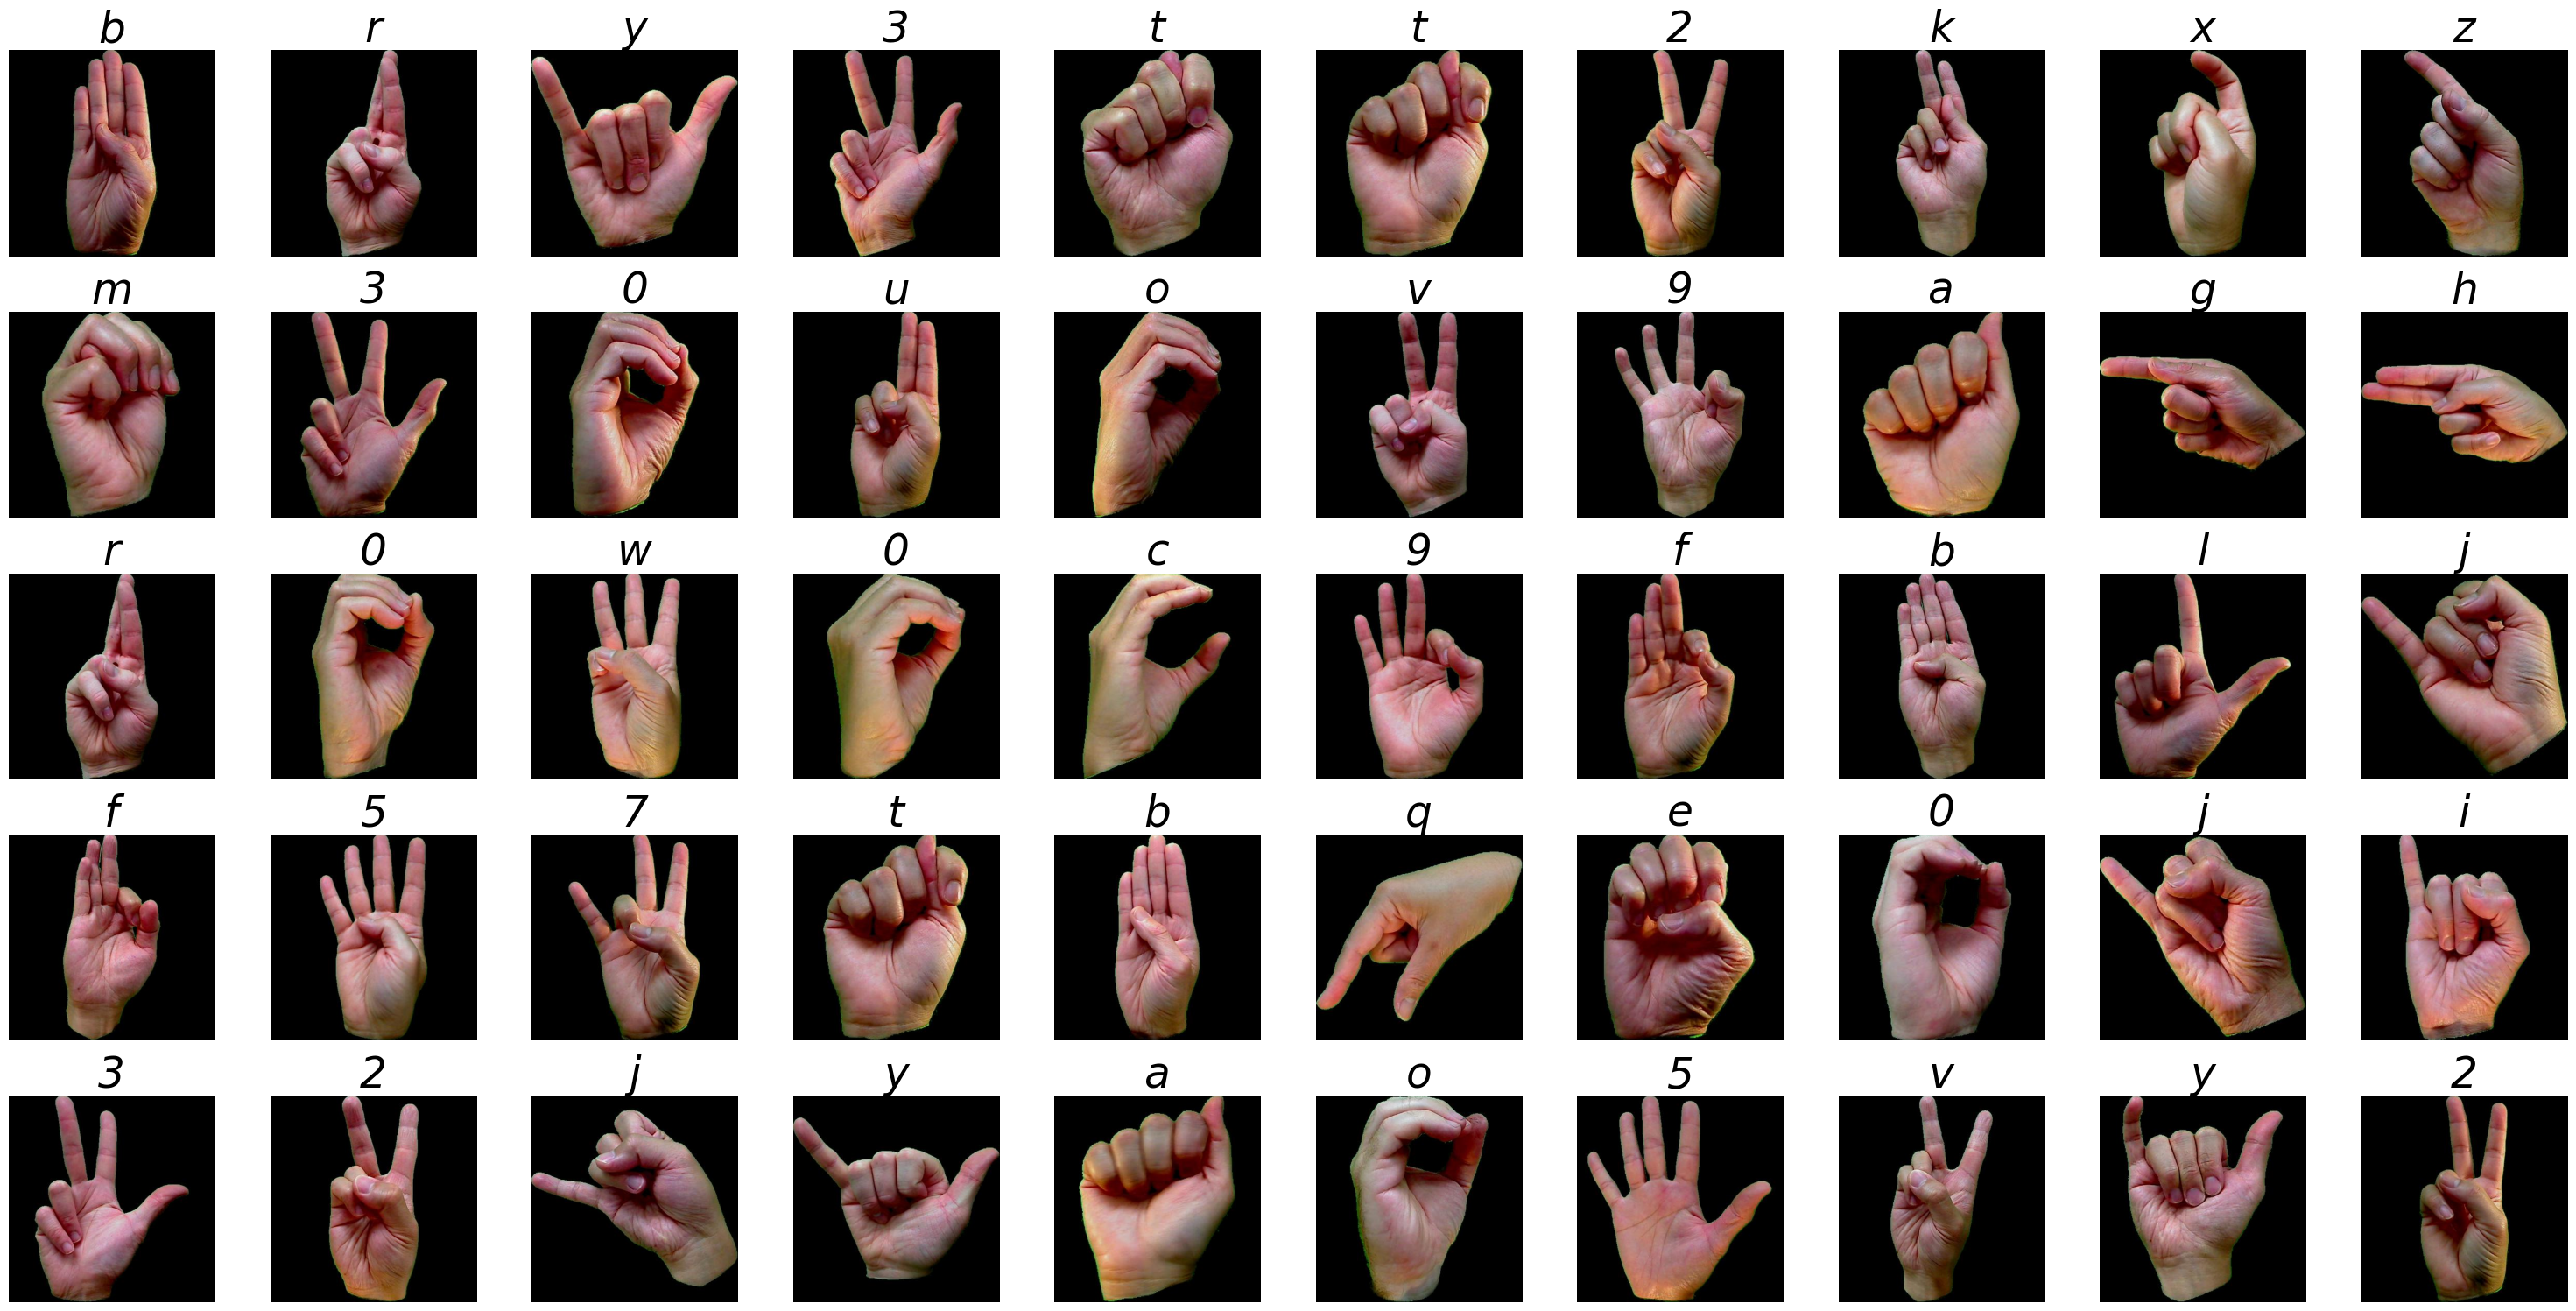

In [7]:
#This code plots the first 50 dataset images, annotating each with its category label, 
#and organizes them in a grid layout with adjusted spacing and font styling for clarity.

plt.figure(figsize=(30,30))

# Loop to plot images
for i in range(50):
    # Construct the full path to the image
    path = os.path.join(first_path, df.filename.iloc[i])
    # Read the image
    img = plt.imread(path)

    # Plotting
    plt.subplot(10, 10, i + 1)
    plt.imshow(img)
    # Use 'df.category.iloc[i]' directly to get the category name
    plt.title(df.category.iloc[i], fontsize=35, fontstyle='italic')
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2.2 Data Visualisation  <a class="anchor" id="Data-Visualisation"></a>

The dataset is highly uniform, with most categories containing exactly 70 items each. This balance is beneficial for training machine learning models, avoiding bias towards certain classes. However, one category ('t') deviates slightly with only 65 items, which could impact performance on less-represented classes. Overall, the dataset is well-prepared for equitable learning across diverse classes.

In [6]:
# df is DataFrame and 'category' is the column with category labels
category_counts = df['category'].value_counts()
print("Number of items in each category:")
print(category_counts)

Number of items in each category:
category
b    70
r    70
y    70
3    70
2    70
k    70
x    70
z    70
0    70
m    70
u    70
o    70
g    70
v    70
9    70
a    70
w    70
h    70
c    70
f    70
d    70
l    70
j    70
5    70
7    70
q    70
e    70
i    70
8    70
1    70
n    70
4    70
p    70
s    70
6    70
t    65
Name: count, dtype: int64


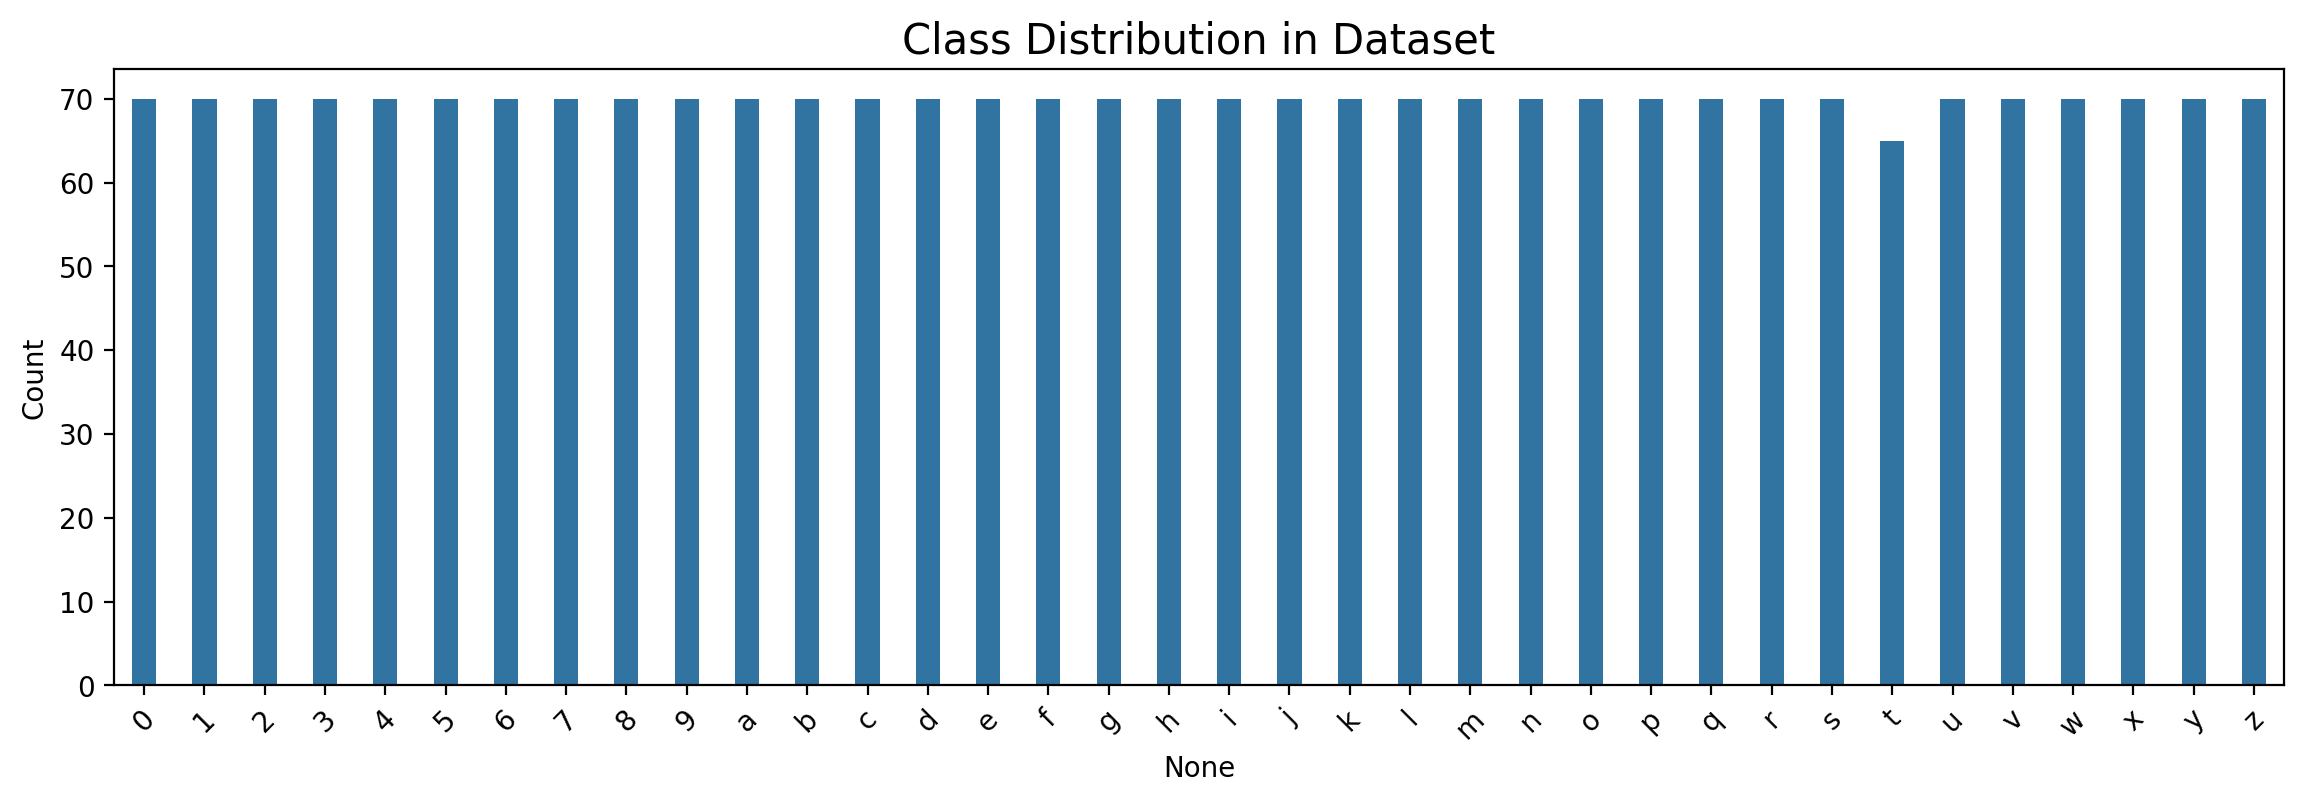

In [8]:
# Assuming df is your DataFrame with a 'category' column
label, count = np.unique(df['category'], return_counts=True)

# Create a DataFrame from the labels and counts
# Assuming 'label' contains the correct category names directly
uni = pd.DataFrame(data=count, index=label, columns=['Count'])

# Plotting
plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(x=uni.index, y='Count', data=uni, width=0.4).set_title('Class Distribution in Dataset', fontsize=15)
plt.xticks(rotation=45)  # Rotate the labels to avoid overlap, adjust as needed
plt.show()

# 3. Data Preprocessing <a class="anchor" id="Data-Preprocessing"></a>

## 3.1. Training, Test and Validation Split <a class="anchor" id="Training,-Test-and-Validation-Split"></a>

The code block divides the dataset into training, validation, and testing subsets. Initially, it splits the data into a 70% training set and a 30% temporary set using stratified sampling. Then, the temporary set is further divided into 15% validation and testing sets each, maintaining category distribution. This ensures thorough data separation for model training and evaluation.

In [37]:
# First, split into train and temp (combining validation and test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])

# Now split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])


## 3.2. Training and Data Augmentation <a class="anchor" id="Training-and-Data-Augmentation"></a>

This code block sets up data preprocessing and augmentation necessary for training, validating, and testing a machine learning model that processes images. 

This setup includes the necessary steps for normalizing image data, configuring image augmentation for training data to introduce variability and prevent overfitting, and preparing data generators that facilitate the efficient flow of data into the model during training and evaluation. The use of categorical class modes is particularly suited for classification tasks with multiple classes, such as this one involving different ASL signs.

During the development of our image preprocessing pipeline, various data augmentation techniques such as rotation, shifts, shear, zoom, and flipping were tested. However, after careful evaluation, simple rescaling of images by a factor of 1./255 was found to deliver the best performance. This method effectively normalizes pixel values while preserving the original data integrity, ensuring optimal learning outcomes.

In [38]:
#Data augmentation is a technique used to enhance the diversity of data available for training models, without actually collecting new data. 
#This is achieved through random transformations that alter the training images but do not change their labels.

# Initialize an ImageDataGenerator for training data with normalization of pixel values
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

# For validation and test data, only rescaling is needed
test_val_datagen = ImageDataGenerator(rescale=1./255)

#These codes configures a generator to process images from a specified directory based on the details provided in a DataFrame. 
#It adjusts image sizes to 200x200 pixels, processes images in batches of 32, and encodes labels in a one-hot categorical format. 
#The generator is used to facilitate the efficient loading and preprocessing of images for feeding into the model during training or evaluation phases.

# Set up a generator to process and augment training images from the directory
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=first_path,
    x_col='filename',
    y_col='category',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

# Set up a generator for validation data with the same configurations as the training data but without augmentation
validation_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=first_path,
    x_col='filename',
    y_col='category',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

# Set up a generator for test data, similar to validation, but with shuffling disabled to preserve order for evaluation
test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=first_path,
    x_col='filename',
    y_col='category',
    target_size=(200, 200),
    batch_size=32,
    shuffle=False,  # Important for test set
    class_mode='categorical'
)


Found 1760 validated image filenames belonging to 36 classes.
Found 377 validated image filenames belonging to 36 classes.
Found 378 validated image filenames belonging to 36 classes.


# 4. Model Development and Optimization <a class="anchor" id="Model-Development-and-Optimization"></a>

## 4.1 Model Exploration and Configuration <a class="anchor" id="Model-Exploration-and-Configuration"></a>

This section outlines the configuration and architecture of the convolutional neural network (CNN) designed for the task of translating ASL hand gestures into text. The model uses a combination of convolutional, pooling, and dense layers, paired with dropout layers to mitigate overfitting. Here’s a detailed breakdown:

<h3>Model Configuration:</h3>

**batch_size** = 32: The model processes 32 images per batch, which is a standard size that balances memory usage and model performance.

**image_size** = 200: All input images are resized to 200x200 pixels, providing a uniform input size.

**img_channel** = 3: The model expects color images with three channels (RGB).

**n_classes** = 36: The output layer has 36 nodes corresponding to the 26 letters of the alphabet plus ten digits (0-9), representing each possible ASL gesture.

<h3>Building the Model:</h3>

The model uses the Keras Sequential API to stack layers in a linear format.

**Convolutional Layers:** Multiple Conv2D layers with ReLU activation functions are used to extract features from the images. Each set of two convolutional layers is followed by a MaxPooling2D layer to reduce the spatial dimensions of the feature maps.

**Pooling Layers:** MaxPooling2D layers reduce the dimensionality of the feature maps, thus reducing the number of parameters and computation in the network.

**Dropout Layers:** Placed after pooling layers and between dense layers, these randomly drop a fraction of the nodes (ranging from 20% to 40%) to prevent overfitting by providing a form of regularization.

**Flatten Layer:** Converts the pooled feature maps into a single vector that can be fed into the dense layers, which are fully connected.

**Dense Layers:** A series of dense (fully connected) layers with ReLU activation lead up to the final output layer, increasing the network's learning capacity.

**Output Layer:** The final dense layer uses softmax activation to output probabilities for the 36 classes.

<h3>Compiling the Model:</h3>

The model is compiled with the Adam optimizer, a popular choice that combines the benefits of two other extensions of stochastic gradient descent. It uses categorical crossentropy as the loss function, which is suitable for multi-class classification problems.The model metrics include accuracy, which is a common metric for classification tasks.

This architecture is designed to effectively learn from the ASL dataset by capturing spatial hierarchies for recognizing hand gestures through successive convolutional and pooling layers, while dropout layers help in avoiding overfitting to the training data.


In [39]:
# Model configuration
batch_size = 32
image_size = 200
img_channel = 3
n_classes = 36

# Building the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, img_channel)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(n_classes, activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 64)      36928     
                                                      

This model was iterated through various designs and adjustments to achieve optimal performance. Initially inspired by VGG architecture, the model encountered overfitting issues in its first attempt, prompting increased dropout implementation. Despite mitigating overfitting, challenges persisted in distinguishing similar ASL signs, leading to further adjustments in dropout rates and layer configurations. However, increasing model complexity resulted in impractical training durations, necessitating optimization of learning rates and batch normalization. The final model, with 36 output units, strategically balances architecture with dropout and precise configurations, effectively merging VGG's strengths with tailored adaptations for high accuracy and generalizability in ASL classification.

## 4.2. Model Fine-Tuning and Integration <a class="anchor" id="Model-Fine-Tuning-and-Integration"></a>

To enhance the model's performance and efficiency, fine-tuning strategies like early stopping and learning rate reduction on plateau are employed:

**Early Stopping** ensures training halts when no improvement in validation loss is observed for five epochs, avoiding overfitting and ensuring the best model weights are retained.

**Reduce Learning Rate on Plateau** lowers the learning rate when the validation loss stops improving, with a patience of five epochs, facilitating finer model adjustments and preventing the learning rate from becoming too small.

These fine-tuning strategies implemented in this project go beyond mere computational efficiency; they are crucial in crafting a model that is both intricate enough to decode the complexities of ASL and versatile enough to maintain accuracy across diverse, unseen data. Achieving this equilibrium is essential for the model's effectiveness in real-world applications, ensuring it can reliably interpret a wide range of ASL gestures under various conditions.


In [40]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    min_delta=0.001,
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored metric
)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    min_lr=0.001  #Lower bound on the learning rate
)


The ASL recognition model is trained for 25 epochs, chosen after experimentation to balance learning and overfitting. With steps_per_epoch and validation_steps calculated based on batch size, each epoch efficiently cycles through the data. Utilizing callbacks like early_stopping and reduce_lr enhances model training by preventing overfitting and adjusting learning rates. This systematic approach ensures a well-generalized and efficient model, optimizing training for accurate ASL classification.

In [41]:
# Adding callbacks to model.fit()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]  # Include callbacks here
)

Epoch 1/25
55/55 [==============================] - 9s 123ms/step - loss: 2.4646 - accuracy: 0.3125 - val_loss: 0.7592 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 2/25
55/55 [==============================] - 6s 115ms/step - loss: 0.8365 - accuracy: 0.7568 - val_loss: 0.3764 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 3/25
55/55 [==============================] - 7s 119ms/step - loss: 0.4034 - accuracy: 0.8773 - val_loss: 0.3708 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 4/25
55/55 [==============================] - 7s 120ms/step - loss: 0.2884 - accuracy: 0.9119 - val_loss: 0.1812 - val_accuracy: 0.9489 - lr: 0.0010
Epoch 5/25
55/55 [==============================] - 7s 123ms/step - loss: 0.1841 - accuracy: 0.9352 - val_loss: 0.1648 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 6/25
55/55 [==============================] - 7s 117ms/step - loss: 0.1283 - accuracy: 0.9568 - val_loss: 0.1975 - val_accuracy: 0.9489 - lr: 0.0010
Epoch 7/25
55/55 [==============================] - 7s 119ms/step - lo

In [42]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


11/11 [==============================] - 1s 94ms/step - loss: 0.1568 - accuracy: 0.9403
Test Loss: 0.15679945051670074, Test Accuracy: 0.9403409361839294


During training, the model exhibited consistent improvement in both training and validation accuracy across epochs. However, after epoch 8, although the training accuracy continued to rise, the validation accuracy plateaued, indicating potential overfitting. This observation was confirmed by the early stopping callback, which terminated training after epoch 13 to prevent further overfitting. The final test accuracy was 94.03%, indicating robust performance on unseen data.

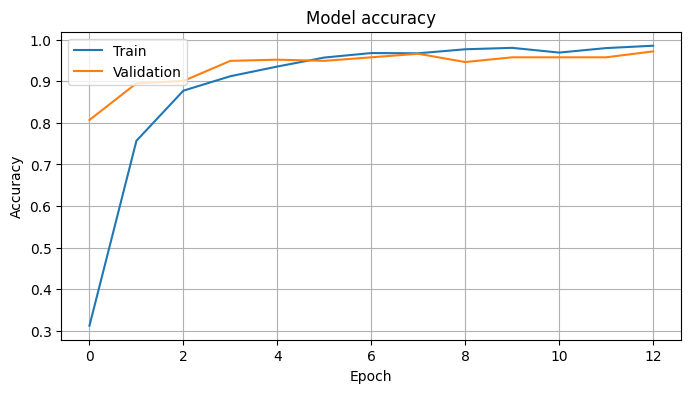

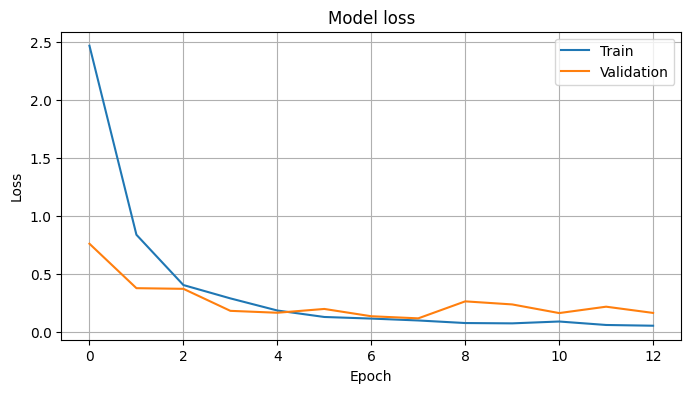

In [44]:
#MODEL ACCURACY
plt.figure(figsize=(8, 4))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

#MODEL LOSS
plt.figure(figsize=(8, 4))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


The training and validation accuracy graphs from the project reveal a model that is learning effectively, as demonstrated by the increasing accuracy over epochs. However, the plateauing of the validation accuracy alongside the continued improvement in training accuracy suggests a potential onset of overfitting.

Concurrently, the decreasing trend in both training and validation loss indicates that the model is becoming better at making accurate predictions. The graphs also suggest that the model may have reached the limits of learning from the current dataset, prompting considerations for architecture alterations or additional data sources.

In [43]:
# Calculate the correct number of steps
steps = np.ceil(test_generator.n / test_generator.batch_size)

# Generate predictions
predictions = model.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# The true_classes array length might not match the predicted_classes length
# due to the rounding up of steps, so we need to adjust true_classes accordingly
true_classes = test_generator.classes[:len(predicted_classes)]

# Now, generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys()))
print(report)


12/12 [==============================] - 2s 178ms/step
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.82      0.82      0.82        11
           2       1.00      0.45      0.62        11
           3       0.92      1.00      0.96        11
           4       0.91      1.00      0.95        10
           5       1.00      1.00      1.00        10
           6       0.77      0.91      0.83        11
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
           a       1.00      1.00      1.00        11
           b       1.00      1.00      1.00        11
           c       1.00      0.90      0.95        10
           d       1.00      1.00      1.00        10
           e       1.00      1.00      1.00        11
           f       1.00      1.00      1.00        10
           g       1.00   

12/12 [==============================] - 1s 95ms/step


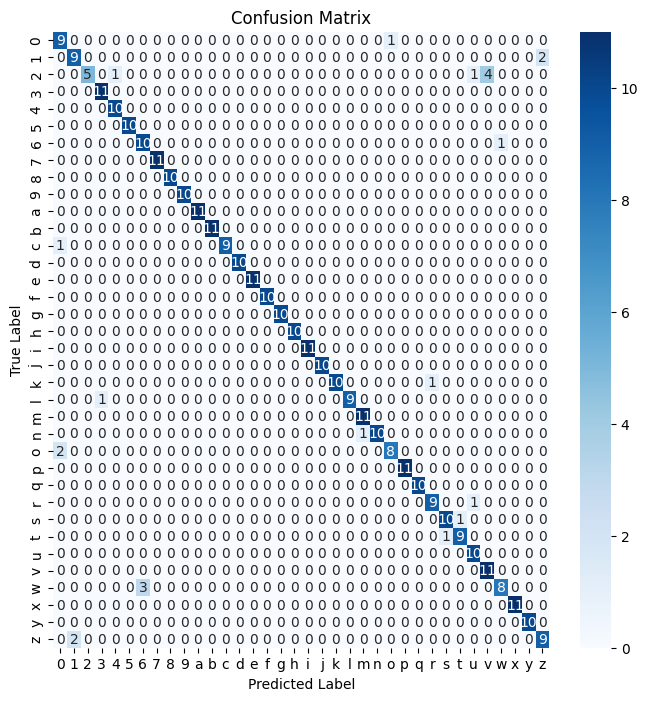

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For a nicer confusion matrix visualization

# Generate predictions and true labels
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=np.ceil(test_generator.n / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)
true_labels = true_labels[:len(predicted_classes)]  # Adjust true labels if necessary

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


The classification report reveals that most classes are predicted with high precision, recall, and F1-scores, indicating effective model performance in correctly identifying true positives. However, specific classes like '2', 'u', and 'v' show notably lower scores, suggesting the model struggles with these categories, potentially due to subtle feature distinctions or insufficient training data. Despite some variation in class representation, as suggested by the support values, no extreme data imbalance is apparent. 

The confusion matrix shows high true positives along the diagonal, indicating strong performance across many classes. However, certain classes show confusion with others, suggesting either a similarity in features that the model struggles to differentiate or a need for more representative data for these classes. Additionally, some classes show a smaller number of true positives, which might point to class imbalance or a need for improved feature extraction for these specific gestures.

# 5. Model Visualization <a class="anchor" id="Model-Visualization"></a>

## 5.1. Attention Layer Identification <a class="anchor" id="Attention-Layer-Identification"></a>

This code block prepares an image for model prediction by preprocessing it, then identifies the index of a specific layer named "conv2d_11" in the loaded model. This layer is crucial for generating attention heatmaps, aiding in interpreting the model's decision-making process during prediction.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Assuming 'model' is already loaded and defined in your session
# Make sure the 'model' here is the correct instance that has been trained or loaded.

# Function to preprocess the image for model prediction
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img /= 255.0  # Normalize the image to [0, 1]
    img = np.expand_dims(img, axis=0)
    return img

# Iterate through the layers of the model and print their names and indices
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")

# Identify the attention layer by its name and retrieve its index
attn_layer_name = "conv2d_11" 
attn_layer_index = None
for i, layer in enumerate(model.layers):
    if layer.name == attn_layer_name:
        attn_layer_index = i
        break

if attn_layer_index is not None:
    print(f"The index of the attention layer '{attn_layer_name}' is: {attn_layer_index}")
else:
    print(f"Attention layer '{attn_layer_name}' not found in the model.")


Layer 0: conv2d_6
Layer 1: conv2d_7
Layer 2: max_pooling2d_3
Layer 3: dropout_5
Layer 4: conv2d_8
Layer 5: conv2d_9
Layer 6: max_pooling2d_4
Layer 7: dropout_6
Layer 8: conv2d_10
Layer 9: conv2d_11
Layer 10: max_pooling2d_5
Layer 11: dropout_7
Layer 12: flatten_1
Layer 13: dense_3
Layer 14: dropout_8
Layer 15: dense_4
Layer 16: dropout_9
Layer 17: dense_5
The index of the attention layer 'conv2d_11' is: 9


## 5.2. Grad-CAM Heatmap Generation <a class="anchor" id="Grad-CAM-Heatmap-Generation"></a>

This code block implements Grad-CAM (Gradient-weighted Class Activation Mapping) provide valuable insights into the model's decision-making process, helping interpret and validate its predictions. These visualizations aid in understanding which image features the model focuses on during classification, enhancing model interpretability and trustworthiness.

<h3>Description:</h3>

**Grad-CAM Heatmap Generation:** The make_gradcam_heatmap function calculates the Grad-CAM heatmap for a given image array, model, and the name of the last convolutional layer. It overlays the gradients of the predicted class activation on the last convolutional layer's output, producing a heatmap that highlights important image regions.

**Display Function:** The display_images_with_heatmaps function visualizes original images alongside their corresponding Grad-CAM heatmaps. For each image, the heatmap is superimposed on the original image, emphasizing regions influencing the model's prediction. Predicted classes and confidence percentages are also displayed for reference.

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


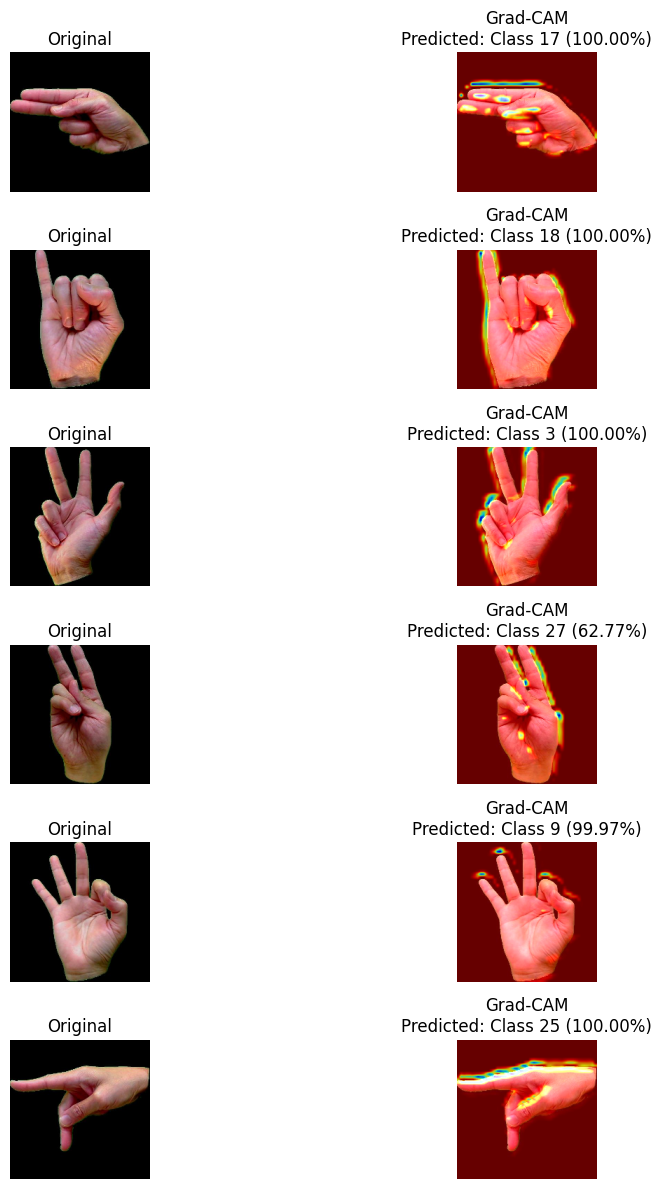

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_channel = preds[:, class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap[0].numpy()  # Return the heatmap as a numpy array

# Display function for images and heatmaps with predictions
def display_images_with_heatmaps(generator, model, last_conv_layer_name, num_images=6):
    plt.figure(figsize=(12, 2 * num_images))

    for i in range(num_images):
        # Process each image
        img, _ = next(generator)
        img_array = np.expand_dims(img[0], axis=0)  # Add batch dimension
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        heatmap_resized = cv2.resize(heatmap, (200, 200))
        heatmap_img = np.uint8(255 * heatmap_resized)
        heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)

        # Get prediction
        pred = model.predict(img_array)
        predicted_class = np.argmax(pred[0])
        confidence = np.max(pred[0]) * 100  # Convert probability to percentage

        # Superimpose the heatmap on original image
        superimposed_img = heatmap_img * 0.8 + img[0] * 255

        # Plot original and heatmap
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(img[0])
        plt.title("Original")
        plt.axis('off')

        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(superimposed_img / 255)
        plt.title(f"Grad-CAM\nPredicted: Class {predicted_class} ({confidence:.2f}%)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the display function
display_images_with_heatmaps(test_generator, model, 'conv2d_11', num_images=6)


The Grad-CAM heatmaps demonstrate that the model is appropriately concentrating on the hand gestures to make its predictions, suggesting that it is effectively learning and utilizing the relevant features for classification. However, the extremely high confidence levels (up to 100%) in its predictions, while potentially indicative of strong model performance, could also signal overconfidence. Such high certainty necessitates rigorous validation against external, real-world data to confirm that the model's predictions are not only confident but also correct.

# 6. Conclusion <a class="anchor" id="Conclusion"></a>

In conclusion, this project successfully navigates the development of a CNN model tailored for American Sign Language (ASL) gesture recognition. Through thorough exploratory data analysis (EDA), data preprocessing, and model optimization, the project lays a solid foundation for accurate classification of ASL gestures from images. Key findings from the evaluation phase underscore the model's strengths in achieving high precision and recall across numerous classes, while also identifying areas for improvement, particularly in handling similar signs and addressing class imbalances. The integration of Grad-CAM heatmaps offers valuable insights into the model's decision-making process, enhancing interpretability and trustworthiness. 

BUSINESS APPLICATION:
1. The model can transform ASL education with interactive learning tools, integrated into educational software for personalized experiences and real-time feedback.
  
2. In customer service and public announcements, it enhances accessibility by translating spoken language into ASL on digital signage, ensuring universal access to information.
  
3. In healthcare, it facilitates communication between providers and ASL-reliant patients, enabling remote consultations on telemedicine platforms.
  
4. Integrated into assistive devices like smart glasses or mobile apps, it provides real-time translation of ASL gestures into text or speech, promoting communication and independence.
  
5. Employers can use the model to foster inclusivity in the workplace, integrating it into communication tools for all employees to participate fully in meetings.
  
6. Social media platforms benefit by automatically generating ASL translations for video content, making online content more accessible and inclusive.

Overall, this project represents a significant step towards enhancing communication accessibility, with potential applications spanning education, accessibility services, and healthcare sectors. Continued refinement and collaboration will be essential for further advancing the model's accuracy and real-world deployment.




# 7. References <a class="anchor" id="References"></a>

1. American Sign Language Dataset. (n.d.). Www.kaggle.com. https://www.kaggle.com/datasets/ayuraj/asl-dataset

2. tf.keras.preprocessing.image.ImageDataGenerator. (n.d.). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

3. The Sequential model | TensorFlow Core. (n.d.). TensorFlow. https://www.tensorflow.org/guide/keras/sequential_model

4. Pandas. (2018). Python Data Analysis Library. Pydata.org. https://pandas.pydata.org/

5. Numpy. (2009). NumPy. Numpy.org. https://numpy.org/

6. seaborn. (2012). seaborn: statistical data visualization — seaborn 0.9.0 documentation. Pydata.org. https://seaborn.pydata.org/

7. tf.keras.callbacks.ReduceLROnPlateau | TensorFlow Core v2.1.0. (n.d.). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

8. Precision, Recall, F1 Score and Support https://medium.com/@nirajan.acharya666/understanding-precision-recall-f1-score-andsupport-in-machine-learning-evaluation7ec935e8512e#:~:text=It's%20like%20a%20balance%20between,the%20class%20in%2
(https://medium.com/@nirajan.acharya666/understanding-precision-recall-f1-scoreand-support-in-machine-learning-evaluation7ec935e8512e#:~:text=It's%20like%20a%20balance%20between,the%20class%20in%2

9. Team, K. (n.d.). Keras documentation: Grad-CAM class activation visualization. Keras.io. https://keras.io/examples/vision/grad_cam/